In [1]:
import psycopg2
import datetime
import pytz
from pyiem.plot import MapPlot, whitebluegreenyellowred
import pandas as pd
import numpy as np
from pyiem import iemre

In [8]:
def get_coop(dates):
    ''' Return snowfall obs for the given dates '''
    if len(dates) == 1:
        dates.append( dates[0] )
    IEM = psycopg2.connect(database='coop', host='localhost', port=5555, user='nobody')
    cursor = IEM.cursor()
    data = []
    cursor.execute("""
    WITH obs as (
        SELECT station, sum(snow) from alldata_ia s WHERE s.day in """+str(tuple(dates))+""" 
        and snow >= 0 GROUP by s.station
    )
    SELECT id, 0, obs.sum, ST_x(geom), ST_y(geom), county from stations JOIN obs
    on (obs.station = stations.id) WHERE stations.network = 'IACLIMATE' and
    stations.id not in ('IA0000', 'IAC001', 'IAC002', 'IAC003', 'IAC004', 'IAC005', 'IAC006'
    , 'IAC007', 'IAC008', 'IAC009')
    """)
    for row in cursor:
        data.append(dict(val=row[2], lat=row[4], lon=row[3], label=row[0], source='coop', useme=True))
    
    cursor.close()
    IEM.close()
    return data

crows = get_coop( ['1996-01-26', '1996-01-27'] )

df = pd.DataFrame(crows)

In [9]:
grid = np.ones( (iemre.NX, iemre.NY), 'f') * -1.0
stations = {}

gx = np.digitize(df['lon'], iemre.XAXIS)
gy = np.digitize(df['lat'], iemre.YAXIS)   

for i, row in df.iterrows():
    if gx[i] == iemre.NX:
        gx[i] = iemre.NX-1
    if gy[i] == iemre.NY:
        gy[i] = iemre.NY-1
    if float(row['val']) > grid[gx[i], gy[i]]:
        grid[gx[i], gy[i]] = row['val']
        stations["%s_%s" % (gx[i], gy[i])] = row['label']

#print grid
newrows = []
for i in range(iemre.NX):
    for j in range(iemre.NY):
        if grid[i,j] >= 0:
            newrows.append(dict(lon=iemre.XAXIS[i], lat=iemre.YAXIS[j], val=float(grid[i,j]), useme=True,
                                label=stations["%s_%s" % (i,j)]))
            #print i, j, float(grid[i,j])
            
df2 = pd.DataFrame(newrows)
        

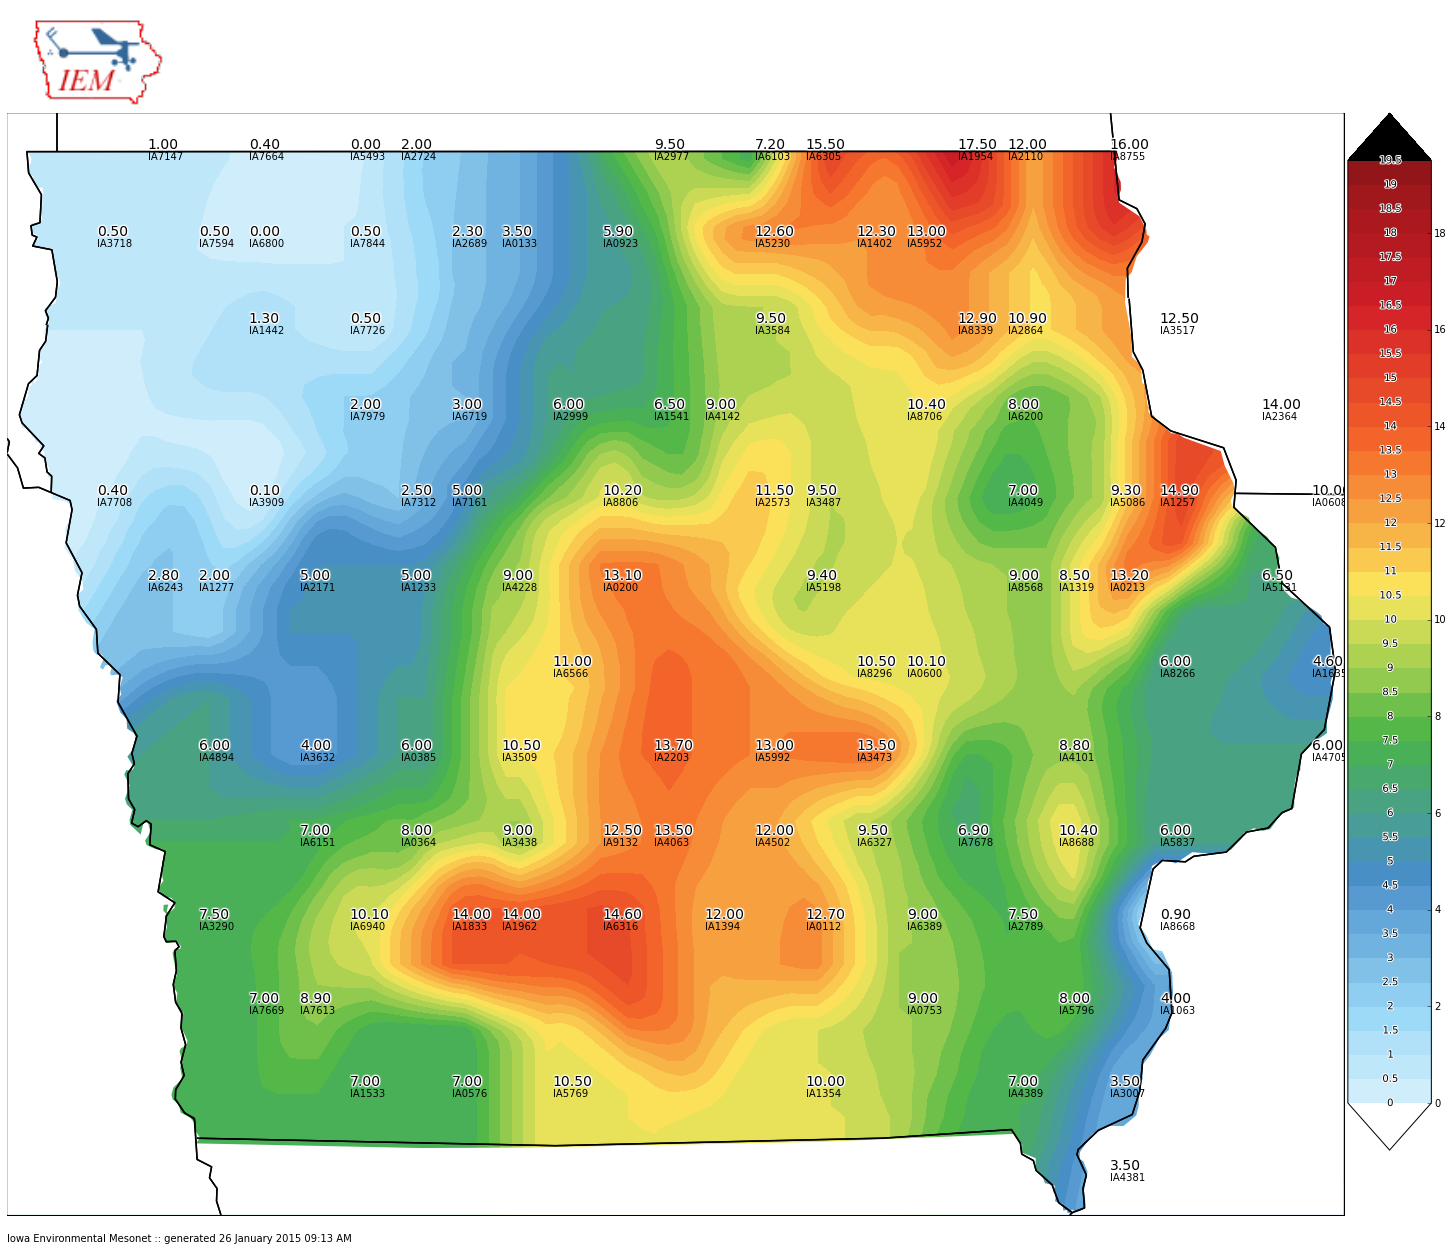

In [15]:
for i, row in df2.iterrows():
    if row['label'] in ('IA0149', 'IA0157', 'IA9067', 'IA4585', 'IA4735') or row['val'] > 120:
        df2['useme'][i] = False
    else:
        df2['useme'][i] = True
cmap = whitebluegreenyellowred()
m = MapPlot(figsize=(20,18))
df3 = df2[df2.useme]
m.contourf(np.array(df3.lon), np.array(df3.lat), np.array(df3.val), np.arange(0,20,0.5), cmap=cmap)
m.plot_values(df3['lon'], df3['lat'], df3['val'], '%.2f', labels=df3.label)

In [1]:
# now we are ready to plot!
clevs = np.array([0.01,0.1,0.25,0.5,1,2,3,5,7,9,11,13,15,17])
m = MapPlot(sector='iowa',
            title="26-27 January 1996 - IEM Snowfall Total Analysis",
            subtitle="Snowfall totals up until 8 AM 28 January 2015")
m.contourf(np.array(df3.lon), np.array(df3.lat), np.array(df3.val), clevs, cmap=cmap)
#m.plot_values(np.array(df2.lon), np.array(df2.lat), np.array(df2.val), '%.2f')
m.drawcounties()
m.postprocess(filename='test.png')


NameError: name 'MapPlot' is not defined